In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import scipy.integrate

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
s = 2

In [4]:
def model(t,z):
  q = z[:s]
  p = z[s:]

  dqdt = p
  dpdt = - q
  dpdt[1:] -= q[1:]**3
  return np.concatenate([dqdt,dpdt])

In [5]:
#Make the dataset
N = 1000
Ntrain = int(0.9 * N)
M = 2 #number of sampled points (after final time)
T = .1 #final sampling time
time = np.linspace(0,T,M)
dt = time[1] - time[0]

realTrajectories = np.zeros([N,2*s,M])
trajectories = np.zeros([N,2*s,M]) #noisy trajectories

q = np.random.rand(N,s)*2-1 #we suppose them organized as z = [q1,...,qs,p1,...,ps]
p = np.random.rand(N,s)*2-1
z = np.concatenate([q,p],axis=1)
realTrajectories[:,:,0] = z

In [6]:
#Generate the dataset
for i in range(N):
  realTrajectories[i,:,:] = scipy.integrate.solve_ivp(model,[0, T],realTrajectories[i,:,0],method='RK45',t_eval=time,atol=1e-12,rtol=1e-10).y

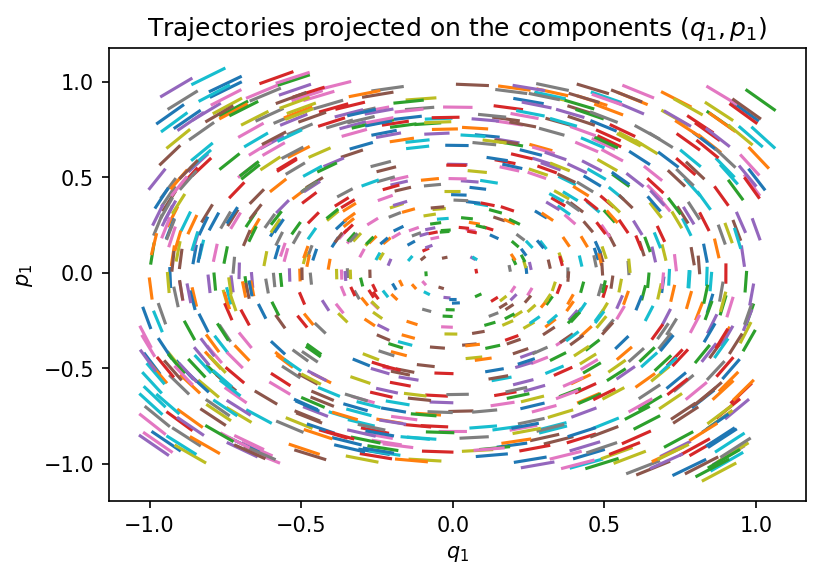

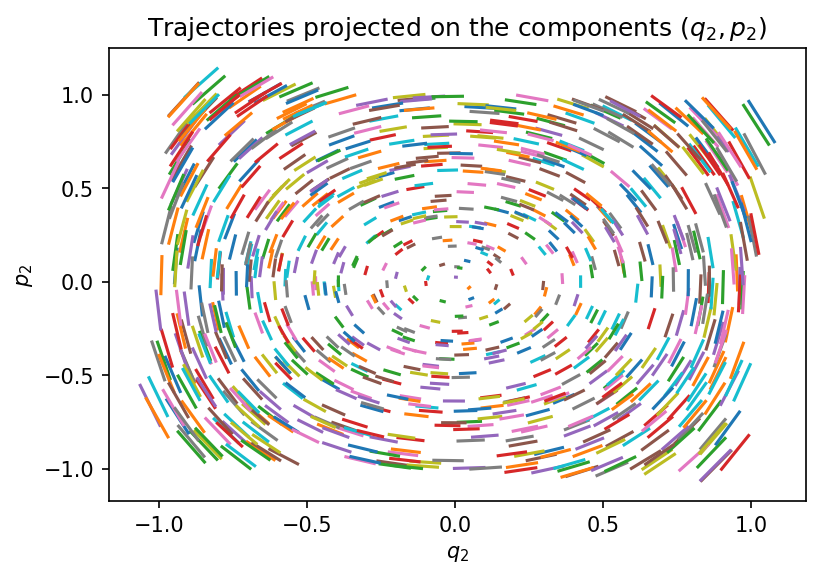

In [7]:
fig, ax = plt.subplots(dpi=150)
for i in range(N):
  plt.plot(realTrajectories[i,0],realTrajectories[i,2])
  plt.xlabel(r"$q_1$")
  plt.ylabel(r"$p_1$")
plt.title(r"Trajectories projected on the components $(q_1,p_1)$")
plt.show()
fig, ax = plt.subplots(dpi=150)
for i in range(N):
  plt.plot(realTrajectories[i,1],realTrajectories[i,3])
  plt.xlabel(r"$q_2$")
  plt.ylabel(r"$p_2$")
plt.title(r"Trajectories projected on the components $(q_2,p_2)$")
plt.show()

In [8]:
epsilons = np.array([0.01,0.02,0.03,0.04,0.05,0.06])*10

In [9]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.astype(np.float32)).to(device)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

batch_size = 100

In [10]:
K = 30
Nl = 2

class Hamiltonian(nn.Module):
    def __init__(self, ):
        super(Hamiltonian, self).__init__()
        
        self.IV = nn.Linear(s,K) 
        self.nl = nn.Tanh()
        
        lin = []
        for i in range(Nl):
          lin.append(nn.Linear(K,K))
          lin.append(self.nl)
        self.seqTr = nn.Sequential(*lin)

        self.OV = nn.Linear(K,1)

        self.A = torch.nn.Parameter(data=torch.Tensor(s,s)) #so that 0.5 * p^T(A^TA)p = K(p)
        self.A.data.copy_(torch.randn(s,s))
        self.A.to(device)
        
    def Kinetic(self, X):
        k = (0.5 * torch.linalg.norm(X[:,s:]@torch.transpose(self.A,0,1),axis=1)**2).unsqueeze(1)
        return k
    
    def Potential(self, X):
        z = self.nl(self.IV(X[:,0:s])) #first affine+nonliner mapping
        z = self.nl(self.seqTr(z))
        v = self.OV(z) #output transformation
        return v

    def forward(self, X):
        o = self.Potential(X) + self.Kinetic(X)
        return o

In [11]:
I = torch.eye(s)
Z = torch.zeros([s,s])
J1 = torch.cat([Z,I],axis=1)
J2 = torch.cat([-I,Z],axis=1)
J = torch.cat([J1,J2],axis = 0).to(device) #Symplectic matrix

In [12]:
def ExpEuler(HFunc,x0):
  N = len(x0) #number of points I propagate in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*s, M-1]).to(device)
  for i in range(M-1):
    H = torch.sum(HFunc(x)).to(device)
    dH = torch.autograd.grad(H, x, create_graph=True)[0].to(device)
    XH= -dH@J

    x = x + dt * XH 
    sol[:,:,i] = x
  
  return sol #stored trajectories

def StormerVerlet(HFunc,x0):
  N = len(x0) #number of points I propagate in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*s, M-1 ]).to(device)
  for i in range(M-1):

    id = torch.eye(s)
    zz = torch.zeros((s,s))
    
    N0 = torch.cat((id,zz),axis=1).to(device)
    N1 = torch.cat((zz,id),axis=1).to(device)

    H = torch.sum(HFunc(x))
    dH = torch.autograd.grad(H, x, create_graph=True)[0]
    XH= -dH@J
    x = x + dt/2 * (XH[:,s:2*s])@N1 #update p to phalf

    H1 = torch.sum(HFunc(x))
    dH1 = torch.autograd.grad(H1, x, create_graph=True)[0]
    XH1= -dH1@J
    x = x + dt * (XH1[:,0:s])@N0 #update for q 

    H2 = torch.sum(HFunc(x))
    dH2 = torch.autograd.grad(H2, x, create_graph=True)[0]
    XH2= -dH2@J

    x = x + dt/2 * (XH2[:,s:2*s])@N1 #update phalf to pnew
    sol[:,:,i] = x

  return sol #stored trajectories

integrator = StormerVerlet

In [13]:
def train(HFunc,optimizer,criterion,scheduler,reg,trainloader,testloader):
  checkpoint = 20

  if reg:
    print("Training with regularization")
  else:
    print("Training without regularization")

  for epoch in range(100):

      running_loss = 0.0
      
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          inputs.requires_grad_()
          optimizer.zero_grad()

          predicted = integrator(HFunc,inputs)
          if reg:
            intConservation = torch.sum(torch.abs((inputs[:,0:1]**2 + inputs[:,s:s+1]**2) - (predicted[:,0,:]**2+predicted[:,s,:]**2)))
            gamma = 1e-3
            loss = criterion(predicted, labels) + gamma * intConservation
          else:
             loss = criterion(predicted, labels)
          loss.backward()
          optimizer.step()
          
          running_loss += loss.item()

      scheduler.step()
  print('Finished Training')

In [14]:
z.shape

(1000, 4)

In [15]:
def experiment(HFunc,reg,trainloader,testloader):
  #Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(HFunc.parameters(), lr = 0.01)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

  train(HFunc,optimizer,criterion,scheduler,reg,trainloader,testloader)

  TT = 1
  timeEval = np.linspace(0,TT,100)  
  def predictedModel(t,x):
    rr = torch.from_numpy(x.astype(np.float32)).to(device).requires_grad_()
    uu = HFunc(rr.unsqueeze(0))
    dHy = torch.autograd.grad(uu,rr)[0]
    XHH = -dHy@J
    return XHH.detach().cpu().numpy()
  
  #z are the initial conditions
  Ztrue = np.zeros([N-Ntrain,2*s,len(timeEval)])
  for i in range(N-Ntrain):
    Ztrue[i,:,:] = scipy.integrate.solve_ivp(model,[0, TT],z[Ntrain+i,:],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y

  Zpred = np.zeros([N-Ntrain,2*s,len(timeEval)])
  for i in range(N-Ntrain):
    Zpred[i,:,:] = scipy.integrate.solve_ivp(predictedModel,[0, TT],z[Ntrain+i],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y

  cc = np.mean((Zpred-Ztrue)**2)
  
  return cc

In [16]:
def trainNoisy(eps):
  
  print("Test with perturbation rescaling: ",eps)
  ccNoReg = []
  ccReg = []

  times = 5
  for tt in range(times):
    print("We are at test : ",tt)
    trajectories = realTrajectories.copy()
    noise = eps*np.random.randn(N,2*s,M-1)
    trajectories[:,:,1:] += noise
    X = trajectories[:,:,0]
    Y = trajectories[:,:,1:M]
    trainset = dataset(X[:Ntrain,:],Y[:Ntrain])
    testset = dataset(X[Ntrain:,:], Y[Ntrain:])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
    HamR = Hamiltonian()
    HamR.to(device);
    HamNR = Hamiltonian()
    HamNR.to(device);

    #Set them to start with the same random weight initializations

    listParams = []
    for param in HamR.parameters():
      listParams.append(param)

    count = 0
    for param in HamNR.parameters():
      param.data = listParams[count].data
      count+=1

    j=0
    cc = experiment(HamR,j,trainloader,testloader)
    ccNoReg.append(cc)
    print("MSE Loss: ",cc)
    #print("Average Hamiltonian error: ",cc)
    #print("Current mean loss noReg : ",np.mean(ccNoReg))
    j=1
    cc = experiment(HamNR,j,trainloader,testloader)
    ccReg.append(cc)
    print("MSE Loss: ",cc)
    #print("Average Hamiltonian error: ",cc)
  
  tt = np.array([1,2,3,4,5])
  plt.plot(tt,ccNoReg,label="No regularization")
  plt.plot(tt,ccReg,label="Regularization")
  xint = range(min(tt), math.ceil(max(tt))+1);
  plt.xticks(xint);
  plt.xlabel("Number of the experiment",fontsize=15)
  plt.ylabel("Obtained accuracy",fontsize=15)
  plt.legend(fontsize = 15)
  plt.title(r"Comparison test accuracies with $\varepsilon$="+str(eps),fontsize=15);
  plt.show()

Test with perturbation rescaling:  0.1
We are at test :  0
Training without regularization
Finished Training
MSE Loss:  0.005528786863861015
Training with regularization
Finished Training
MSE Loss:  0.0016202026606487276
We are at test :  1
Training without regularization
Finished Training
MSE Loss:  0.0036648846682558497
Training with regularization
Finished Training
MSE Loss:  0.0014246100178990102
We are at test :  2
Training without regularization
Finished Training
MSE Loss:  0.001710492811324825
Training with regularization
Finished Training
MSE Loss:  0.0005411552144906361
We are at test :  3
Training without regularization
Finished Training
MSE Loss:  0.003972203683634716
Training with regularization
Finished Training
MSE Loss:  0.0007248372473428577
We are at test :  4
Training without regularization
Finished Training
MSE Loss:  0.004100640651699962
Training with regularization
Finished Training
MSE Loss:  0.0007999431081278686


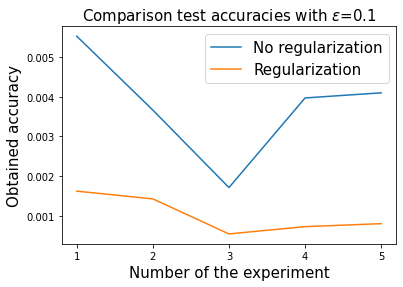

Test with perturbation rescaling:  0.2
We are at test :  0
Training without regularization
Finished Training
MSE Loss:  0.008476758159727782
Training with regularization
Finished Training
MSE Loss:  0.004062932690200115
We are at test :  1
Training without regularization
Finished Training
MSE Loss:  0.008921749085864029
Training with regularization
Finished Training
MSE Loss:  0.00267002920785114
We are at test :  2
Training without regularization
Finished Training
MSE Loss:  0.011453547417178387
Training with regularization
Finished Training
MSE Loss:  0.005281499664551192
We are at test :  3
Training without regularization
Finished Training
MSE Loss:  0.007260886466148585
Training with regularization
Finished Training
MSE Loss:  0.0052576422811992235
We are at test :  4
Training without regularization
Finished Training
MSE Loss:  0.007776679040912892
Training with regularization
Finished Training
MSE Loss:  0.0028231483251509085


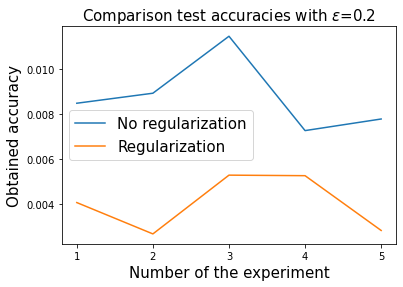

Test with perturbation rescaling:  0.3
We are at test :  0
Training without regularization
Finished Training
MSE Loss:  0.03446628003323425
Training with regularization
Finished Training
MSE Loss:  0.009411696936933984
We are at test :  1
Training without regularization
Finished Training
MSE Loss:  0.02822587577375274
Training with regularization
Finished Training
MSE Loss:  0.012485509780927375
We are at test :  2
Training without regularization
Finished Training
MSE Loss:  0.025884013913884115
Training with regularization
Finished Training
MSE Loss:  0.004685055914933705
We are at test :  3
Training without regularization
Finished Training
MSE Loss:  0.014702227438132624
Training with regularization
Finished Training
MSE Loss:  0.006804426199230801
We are at test :  4
Training without regularization
Finished Training
MSE Loss:  0.02860284344324075
Training with regularization
Finished Training
MSE Loss:  0.010182071502470642


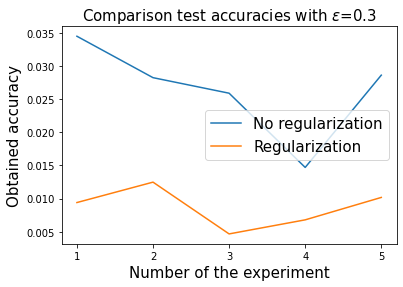

Test with perturbation rescaling:  0.4
We are at test :  0
Training without regularization
Finished Training
MSE Loss:  0.030867714979121854
Training with regularization
Finished Training
MSE Loss:  0.011788517127948364
We are at test :  1
Training without regularization
Finished Training
MSE Loss:  0.036732312380845476
Training with regularization
Finished Training
MSE Loss:  0.016645982317200138
We are at test :  2
Training without regularization
Finished Training
MSE Loss:  0.054174765788961916
Training with regularization
Finished Training
MSE Loss:  0.01939957786582152
We are at test :  3
Training without regularization
Finished Training
MSE Loss:  0.02371297364659767
Training with regularization
Finished Training
MSE Loss:  0.0038482883158406766
We are at test :  4
Training without regularization
Finished Training
MSE Loss:  0.040359340241752265
Training with regularization
Finished Training
MSE Loss:  0.008362095506330783


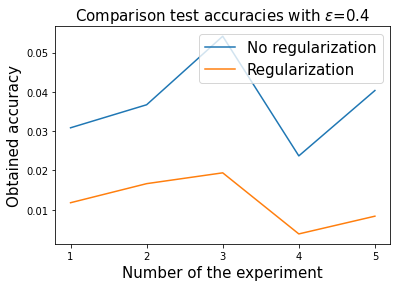

Test with perturbation rescaling:  0.5
We are at test :  0
Training without regularization
Finished Training
MSE Loss:  0.04494793393322297
Training with regularization
Finished Training
MSE Loss:  0.0190715483287562
We are at test :  1
Training without regularization
Finished Training
MSE Loss:  0.02471166774895879
Training with regularization
Finished Training
MSE Loss:  0.008078293032590804
We are at test :  2
Training without regularization
Finished Training
MSE Loss:  0.022726038286425852
Training with regularization
Finished Training
MSE Loss:  0.02084369429216677
We are at test :  3
Training without regularization
Finished Training
MSE Loss:  0.07680111927826647
Training with regularization
Finished Training
MSE Loss:  0.03568414404455665
We are at test :  4
Training without regularization
Finished Training
MSE Loss:  0.06435072076557459
Training with regularization
Finished Training
MSE Loss:  0.03919037426258561


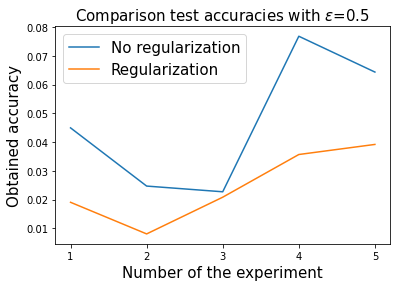

Test with perturbation rescaling:  0.6
We are at test :  0
Training without regularization
Finished Training
MSE Loss:  0.12043494870563543
Training with regularization
Finished Training
MSE Loss:  0.0813682151601621
We are at test :  1
Training without regularization
Finished Training
MSE Loss:  0.041616673407857414
Training with regularization
Finished Training
MSE Loss:  0.018699963342798213
We are at test :  2
Training without regularization
Finished Training
MSE Loss:  0.07939231582655067
Training with regularization
Finished Training
MSE Loss:  0.041239194642325866
We are at test :  3
Training without regularization
Finished Training
MSE Loss:  0.07976345089542963
Training with regularization
Finished Training
MSE Loss:  0.03892068958515817
We are at test :  4
Training without regularization
Finished Training
MSE Loss:  0.0633464869468169
Training with regularization
Finished Training
MSE Loss:  0.03241791210164538


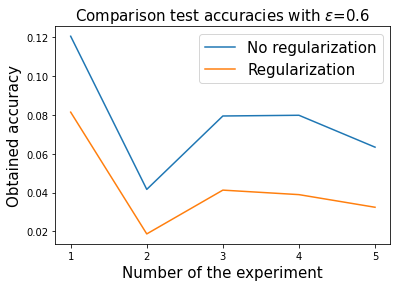

In [17]:
for eps in epsilons : 
  trainNoisy(eps)